In [1]:
#!python3

# imports
from math import exp
import numpy as np
from scipy import integrate
import sdeint
import matplotlib.pyplot as plt

In [2]:
# Model definition

# Logistic growth solution
def log_grow(K, N0, r, t):
    return((K*N0*exp(r*t)) / (K + N0*(exp(r*t) - 1)))

log_grow_vec = np.vectorize(log_grow)

# Model for populations
def dN_dt(N, t, K, r_res, r_chal, a_RC, a_CR):
    return np.array([ N[0]*(r_res/K)*(K-N[0]-a_RC*N[1]),
                   N[1]*(r_chal/K)*(K-N[1]-a_CR*N[0])])

# Closure, for use with sdeint
def dN_dt_stochatic(K, r_res, r_chal, a_RC, a_CR):
    def f(N, t):
        return np.array([ N[0]*(r_res/K)*(K-N[0]-a_RC*N[1]),
                   N[1]*(r_chal/K)*(K-N[1]-a_CR*N[0])])
    return f

# Jacobian
def d2N_dt2(N, t, K, r_res, r_chal, a_RC, a_CR):
    return np.array([[(r_res/K)*(K-2*N[0]-a_RC*N[1]), -(r_res/K)*N[0]*a_RC           ],
                  [-(r_chal/K)*N[1]*a_CR         , (r_chal/K)*(K-2*N[1]-a_CR*N[0])]])

# Brownian motion
def brownian(B_stren):
    B = np.diag([B_stren, B_stren])
    def G(x, t):
        return B  
    return G

In [7]:
# model parameters

# see log_growth_fit.R for estimates
K = 67614            # carrying capacity
r_res = 0.969752     # growth rate (resident)
r_chal = r_res       # growth rate (challenger)

# competition terms
gamma_res_chal = 1 # competition (challenger on resident)
gamma_chal_res = 1 # competition (resident on challenger)
beta = 1.1           # strength of effect of competence

# arrival times (in hours)
t_com = 6      # time for competence to develop
t_chal = 4     # time of arrival of challenger inoculum
t_end = 10     # time to run integration in final step

# starting parameters
C_size = 10000  # size of challenger inoculum
R_size = 100     # size of resident inoculum

# Brownian motion strength
stochastic = False
B_stren = 5000

In [4]:
# Numerical setup

# Number of points per hour
resolution = 5000
def t_range(start, end, resolution):
    assert end > start
    points = int(round(resolution/(end-start)))
    return np.linspace(start, end, points)

# Set up Brownian motion
if stochastic:
    G = brownian(B_stren)

In [8]:
# Run integration in three pieces
t0 = t_range(0, t_chal, resolution)
N0 = np.vstack((log_grow_vec(K, R_size, r_res, t0), np.zeros(t0.shape[0]))).T
N0_end = np.array([log_grow(K, R_size, r_res, t_chal), C_size]) # initial conditions
a_RC = gamma_res_chal
a_CR = gamma_chal_res


if (t_chal < t_com):
    # From arrival of challenger to development of competence
    t1 = t_range(t_chal, t_com, resolution)
    if stochastic:
        f = dN_dt_stochatic(K, r_res, r_chal, a_RC, a_CR)
        N1 = sdeint.itoint(f, G, N0_end, t1)
    else:
        N1 = integrate.odeint(dN_dt, N0_end, t1, args=(K, r_res, r_chal, a_RC, a_CR), Dfun=d2N_dt2)
    
    N1_end = N1[-1,:]
    t2 = t_range(t_com, t_com + t_chal, resolution) 
else:
    # case where t_chal > t_com (only two pieces)
    N1_end = N0
    t2 = t_range(t_chal, t_com + t_chal, resolution)

# From development of competence in resident to development of competence in challenger
a_CR = gamma_chal_res + beta
if stochastic:
    f = dN_dt_stochatic(K, r_res, r_chal, a_RC, a_CR)
    N2 = sdeint.itoint(f, G, N1_end, t2)
else:
    N2 = integrate.odeint(dN_dt, N1_end, t2, args=(K, r_res, r_chal, a_RC, a_CR), Dfun=d2N_dt2)

# From development of competence in resident to development of competence in challenger
t3 = t_range(t_com + t_chal, t_com + t_chal + t_end, resolution)
N2_end = N2[-1,:]
a_RC = gamma_res_chal + beta
if stochastic:
    f = dN_dt_stochatic(K, r_res, r_chal, a_RC, a_CR)
    N3 = sdeint.itoint(f, G, N2_end, t3)
else:
    N3 = integrate.odeint(dN_dt, N2_end, t3, args=(K, r_res, r_chal, a_RC, a_CR), Dfun=d2N_dt2)

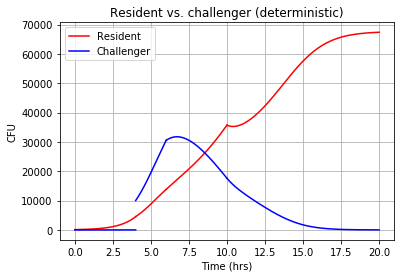

In [9]:
# Draw plot
f1 = plt.figure()
plt.plot(t0, N0[:,0], 'r-', label='Resident')
plt.plot(t0, N0[:,1], 'b-', label='Challenger')

if (t_chal < t_com):
    plt.plot(t1, N1[:,0], 'r-')
    plt.plot(t1, N1[:,1], 'b-')

plt.plot(t2, N2[:,0], 'r-')
plt.plot(t2, N2[:,1], 'b-')

plt.plot(t3, N3[:,0], 'r-')
plt.plot(t3, N3[:,1], 'b-')
    
plt.grid()
plt.legend(loc='best')
plt.xlabel('Time (hrs)')
plt.ylabel('CFU')
if stochastic:
    plt.title('Resident vs. challenger (stochastic)')
    f1.savefig('res_chal_stochastic.pdf')
else:
    plt.title('Resident vs. challenger (deterministic)')
    f1.savefig('res_chal_deterministic.pdf')
plt.show()